Notebook showcasing various examples of use of the algorithm in our ODfunctions library that does not appear in the manuscript "On proportional volume sampling for experimental design in general spaces". Please make sure the working directory is where the "ODfunctions.py" file is and all the required librairies are installed.

In [4]:
import os as os
os.chdir("/home/arnaud/Desktop/Testpython") #Working directory where the "ODfunctions.py" file is.
from ODfunctions import OptDesign, DOGS, LSA, ExM, Discrete_ExM, PHImono #Requires the packages: math, numpy,
#cvxopt, matplotlib, scipy and dppy.
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
import time as time

# 1. Three circles

In this section, we consider the desing space $\Omega=B((0,0),1)\cup B((2,0),1)\cup B((1,\sqrt{3}),1)$ as a toy example. We also consider that the regressing functions are the monomials with degree $\leq 3$ and the number of points in the designs are the same as the number of regressing functions. Note that the algorithm from De Castro et al. did not work in this case.

log D-optimality criterion for this random design chosen with a uniform distribution: -5.741992472051351


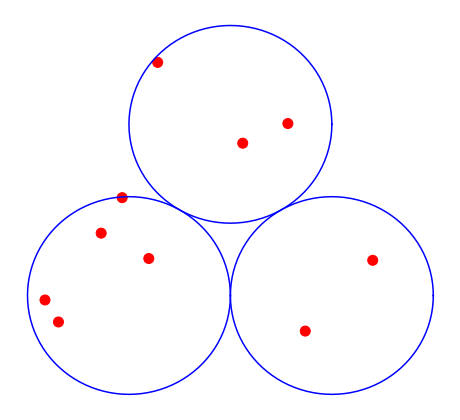

In [16]:
PHI = PHImono(2,3)

def CircCara(P):
    Bool_Ar = np.logical_or(P[:,0]**2+P[:,1]**2 <= 1,(P[:,0]-2)**2+P[:,1]**2 <= 1)
    Bool_Ar = np.logical_or(Bool_Ar,(P[:,0]-1)**2+(P[:,1]-np.sqrt(3))**2 <= 1)
    return(Bool_Ar)

def CircRand(n): #Better sampler for the uniform distribution on the design space than a rejection method.
    A = np.random.rand(n,2)
    a = np.random.randint(low = 1,high = 4,size = n)
    return np.vstack((np.sqrt(A[:,0])*np.cos(2*np.pi*A[:,1])+2*(a == 1)+1*(a == 2),np.sqrt(A[:,0])*np.sin(2*np.pi*A[:,1])+np.sqrt(3)*(a == 2))).T

def Circplot(ax):
    ang=2*np.pi*np.arange(0,1.01,0.01)
    ax.plot(np.cos(ang),np.sin(ang),'b')
    ax.plot(2+np.cos(ang),np.sin(ang),'b')
    ax.plot(1+np.cos(ang),np.sqrt(3)+np.sin(ang),'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI,[-1,-1],[3,1+np.sqrt(3)],cara = CircCara,Urand = CircRand,plot_fun = Circplot)

P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end = " ")
print(OD.opt(P,crit = "D"))
OD.plot(P)

Here is an exemple of a design generated by each algorithm and a comparison of their performances.

log D-optimality criterion for one realization of DOGS after 200 iterations: -24.038123028058173
log D-optimality criterion for one realization of LSA after 2000 iterations: -24.161933528008763
log D-optimality criterion for one realization of ExM after 200 iterations: -20.706394609470255


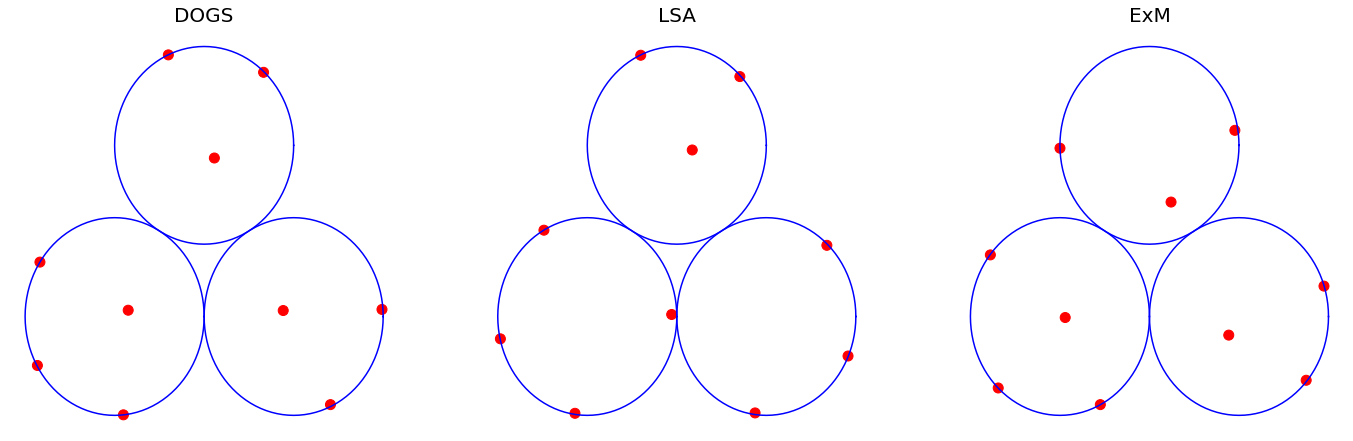

In [17]:
Algo_DOGS=DOGS(OD,50,crit="D")
P1=Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end = " ")
print(OD.opt(P1))

Algo_LSA=LSA(OD,0.05)
P2=Algo_LSA.simulate(2000)
print("log D-optimality criterion for one realization of LSA after 2000 iterations:", end = " ")
print(OD.opt(P2))

Algo_ExM=ExM(OD)
P3=Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end = " ")
print(OD.opt(P3))

fig=OD.plot((P1,P2,P3),modify_plot = True)
fig.axes[0].set_title("DOGS", fontsize = 20)
fig.axes[1].set_title("LSA", fontsize = 20)
fig.axes[2].set_title("ExM", fontsize = 20)
fig

In [18]:
algo_tuple = (ARIFAA(OD),LSA(OD,0.01),LSA(OD,0.05),LSA(OD,0.1),ExM(OD))
depth = 200 #Number of iteration of each algorithm.
N_test = 50 #Number of repetition of each algorithm.
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth,N_test,progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res,axis=0)]
    List_quantile_low += [np.quantile(sim_res,quantile,axis=0)]
    List_quantile_high += [np.quantile(sim_res,1-quantile,axis=0)]
    
Algo_30grid = Discrete_ExM(OD,size = 30)
print("Discrete ExM uses "+str(Algo_30grid.num_point())+" points.")
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_30grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end = " ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Discrete ExM uses 353 points.
Progress: 100.00% 

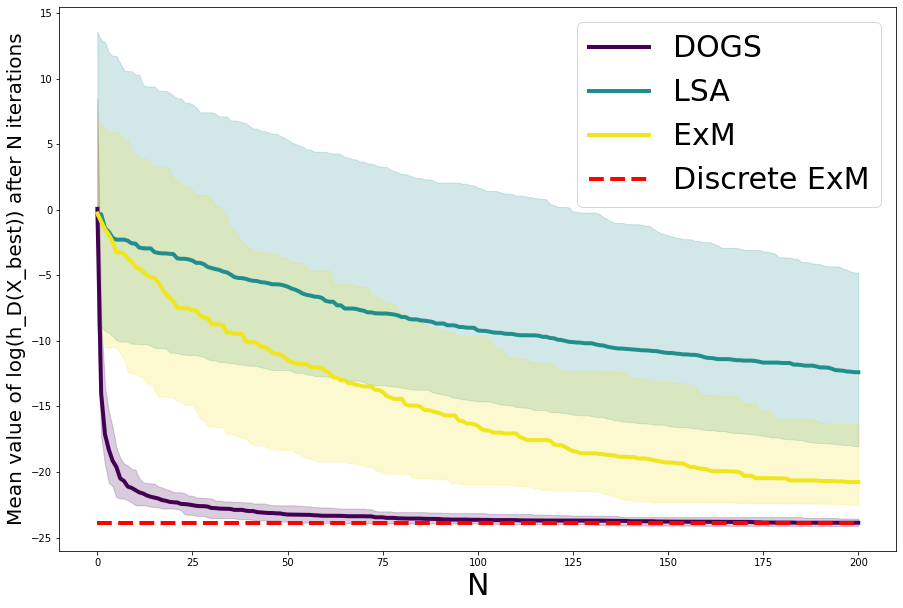

Average time for one realization of 200 iterations of DOGS: 4.471sec
Average time for one realization of 200 iterations of LSA: 0.119sec
Average time for one realization of 200 iterations of ExM: 2.831sec
Average time for one realization of Discrete ExM: 2.729sec


In [19]:
#Plotting the results

plt.figure(figsize = (15,10))
viridis = plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k],linewidth = 4, color = viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0,depth],[m,m],'r--', linewidth = 4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color = viridis(k*0.24), alpha = .2)

plt.legend(labels = ["DOGS","LSA (sd=0.01)","LSA (sd=0.05)","LSA (sd=0.1)","ExM","Discrete ExM"],fontsize = 30)
plt.xlabel('N',fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations',fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

# 2. The Moon

In this section, we consider the desing space $\Omega=B((-0.2,0),0.6)\backslash B((0.6,0),0.4)$. This is the same design space as in the paper of De Castro et al.
We also consider that the regressing functions are the monomials with degree $\leq 2$ and that the number of points in the designs is $50$, much higher than the number of regressing functions, in order to compare our result to the center plot of Figure 5 in the paper of De Castro et al.

log D-optimality criterion for this random design chosen with a uniform distribution: -1.3263857686847007


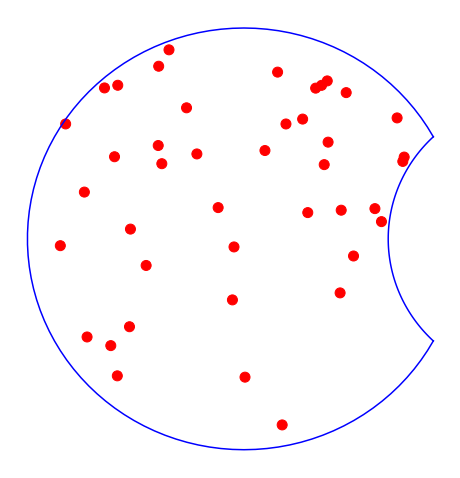

In [35]:
PHI=PHImono(2,2)

def MoonCara(P):
    Bool_Ar=np.logical_and((P[:,0]+0.2)**2+P[:,1]**2<=0.36,(P[:,0]-0.6)**2+P[:,1]**2>=0.16)
    return(Bool_Ar)

def Moonplot(ax):
    ang1=np.arccos((13/40+0.2)/0.6)
    ANG1=np.linspace(ang1,2*np.pi-ang1,100)
    ang2=np.arccos((13/40-0.6)/0.4)
    ANG2=np.linspace(ang2,2*np.pi-ang2,100)
    ax.plot(-0.2+0.6*np.cos(ANG1),0.6*np.sin(ANG1),'b')
    ax.plot(0.6+0.4*np.cos(ANG2),0.4*np.sin(ANG2),'b')
    ax.axis("off")
    return ax

def MoonRand(n):
    A=np.random.rand(n,2)
    P=np.vstack((-0.2+0.6*np.sqrt(A[:,0])*np.cos(2*np.pi*A[:,1]),0.6*np.sqrt(A[:,0])*np.sin(2*np.pi*A[:,1])))
    P=P.T
    P=P[MoonCara(P),:]
    while P.shape[0]<n:
        A=np.random.rand(n,2)
        P2=np.vstack((-0.2+0.6*np.sqrt(A[:,0])*np.cos(2*np.pi*A[:,1]),0.6*np.sqrt(A[:,0])*np.sin(2*np.pi*A[:,1])))
        P2=P2.T
        P2=P2[MoonCara(P2),:]
        P=np.vstack((P,P2))
    return P[:n,:]

OD=OptDesign(PHI,[-0.8,-0.6],[0.325,0.6],nbpoint=42,cara=MoonCara,Urand=MoonRand,plot_fun=Moonplot)
P=OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end=" ")
print(OD.opt(P,crit="D"))
OD.plot(P)

In their article, De castro et al. found the following optimal design:

log D-optimality criterion of the design: -5.999032656277131


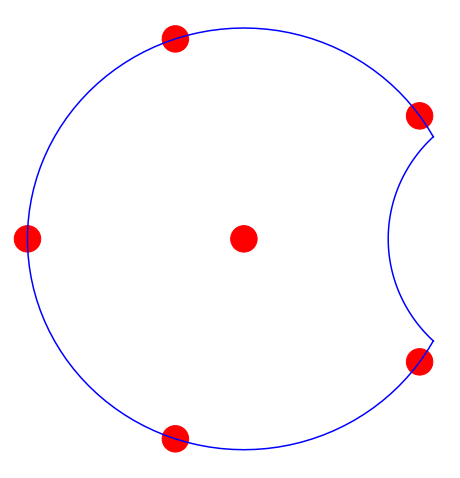

In [36]:
P_opt = np.array([[-0.39,-0.569],[-0.7999,0],[-0.2,0],[0.287,-0.35],[-0.39,0.569],[0.287,0.35]])
P_opt = np.vstack((P_opt,P_opt,P_opt,P_opt,P_opt,P_opt,P_opt))
print("log D-optimality criterion of the design:", end = " ")
print(OD.opt(P_opt))
OD.plot(P_opt)

Here is an exemple of a design generated by each algorithm and a comparison of their performances. We can already see in the examples that the designs closer to the results from De Castro et al. are the one generated by DOGS.

log D-optimality criterion for one realization of ARIFAA after 200 iterations: -5.541045867736489
log D-optimality criterion for one realization of LSA after 200 iterations: -4.440884613770475
log D-optimality criterion for one realization of ExM after 200 iterations: -5.528177828951594


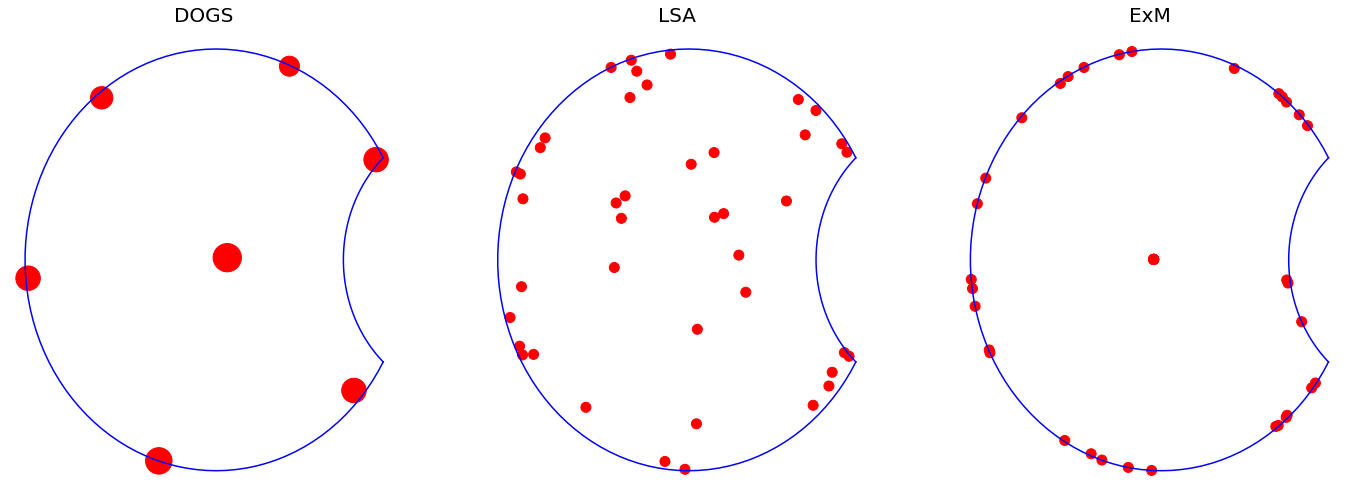

In [23]:
Algo_DOGS = DOGS(OD)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of ARIFAA after 200 iterations:", end = " ")
print(OD.opt(P1))

Algo_LSA = LSA(OD,0.05)
P2 = Algo_LSA.simulate(200)
print("log D-optimality criterion for one realization of LSA after 200 iterations:", end = " ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end = " ")
print(OD.opt(P3))

fig = OD.plot((P1,P2,P3),modify_plot = True)
fig.axes[0].set_title("DOGS", fontsize = 20)
fig.axes[1].set_title("LSA", fontsize = 20)
fig.axes[2].set_title("ExM", fontsize = 20)
fig

Now, we compare the performances of all algorithms.

In [24]:
algo_tuple = (ARIFAA(OD),LSA(OD,0.01),LSA(OD,0.05),LSA(OD,0.1),ExM(OD))
depth = 200
N_test = 10
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth,N_test,progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res,axis=0)]
    List_quantile_low += [np.quantile(sim_res,quantile,axis=0)]
    List_quantile_high += [np.quantile(sim_res,1-quantile,axis=0)]
    
Algo_25grid = Discrete_ExM(OD,size = 25)
print("Discrete ExM uses "+str(Algo_30grid.num_point())+" points.")
N_discrete_test = 5

Discrete_Result = []
Discrete_Time = []
for i in range(N_discrete_test):
    t_up = time.time()
    Pt = Algo_25grid.simulate()
    t_down = time.time()
    Discrete_Time += [t_down-t_up]
    Discrete_Result += [OD.opt(Pt)]
    print('\rProgress: '+f'{100*(i+1)/N_discrete_test:.2f}'+'%', end = " ")

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Discrete ExM uses 353 points.
Progress: 100.00% 

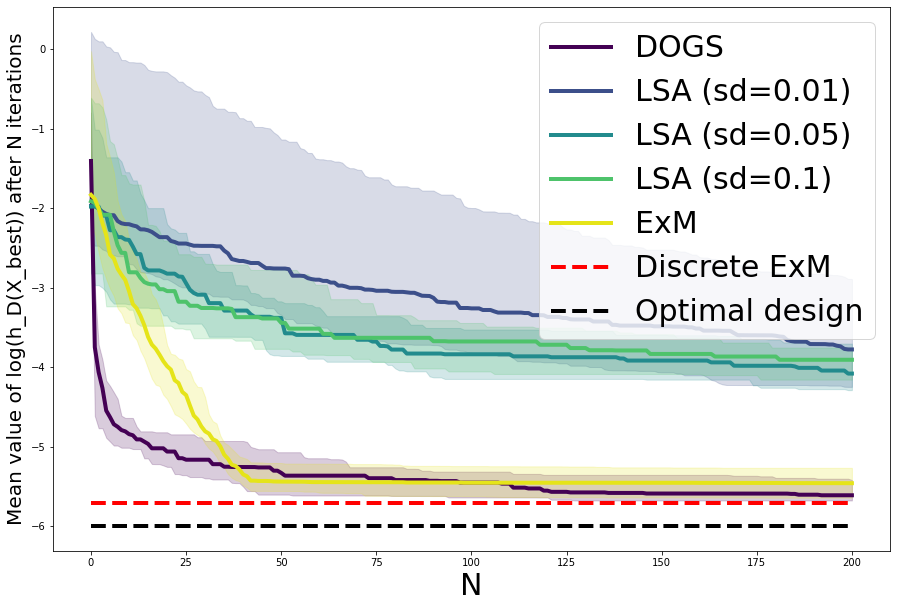

Average time for one realization of 200 iterations of DOGS: 1.654sec
Average time for one realization of 200 iterations of LSA: 0.096sec
Average time for one realization of 200 iterations of ExM: 2.399sec
Average time for one realization of Discrete ExM: 5.432sec


In [37]:
#Plotting the results

plt.figure(figsize = (15,10))
viridis = plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k],linewidth = 4, color = viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0,depth],[m,m],'r--', linewidth = 4)
plt.plot([0,depth],[OD.opt(P_opt),OD.opt(P_opt)],'--', color = "black" , linewidth = 4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color = viridis(k*0.24), alpha = .2)

plt.legend(labels = ["DOGS","LSA (sd=0.01)","LSA (sd=0.05)","LSA (sd=0.1)","ExM","Discrete ExM","Optimal design"],fontsize = 30)
plt.xlabel('N',fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations',fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');
print(f'Average time for one realization of Discrete ExM: {np.mean(Discrete_Time):.3f}sec');

# 3. Internal combustion engine performance

This example is taken from Example 12.2 in the book "Optimum Experimental Designs, with SAS" by Atkinson, Donev and Tobias.

log D-optimality criterion for this random design chosen with a uniform distribution: -15.407415757220372


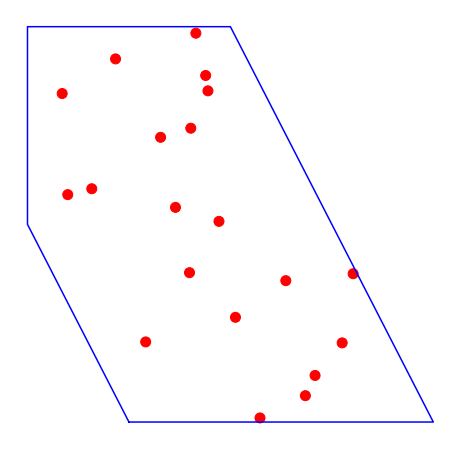

In [38]:
PHI=PHImono(2,2)

def EngineCara(P):
    Bool_Ar=np.logical_and(P[:,0]>=0,P[:,1]>=0)
    Bool_Ar=np.logical_and(Bool_Ar,P[:,1]<=4)
    Bool_Ar=np.logical_and(Bool_Ar,P[:,1]+2*P[:,0]>=2)
    Bool_Ar=np.logical_and(Bool_Ar,P[:,1]+2*P[:,0]<=8)
    return(Bool_Ar)

def Engineplot(ax):
    ax.plot([1,4,2,0,0,1],[0,0,4,4,2,0],'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI,[0,0],[4,4],nbpoint = 20,cara = EngineCara,plot_fun = Engineplot)
P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end = " ")
print(OD.opt(P))
OD.plot(P)

They found the following optimal design by running a discrete optimization algorithm on a discrete set of well-chosen candidate points.

Optimal log D-optimality criterion: -21.53708927176649


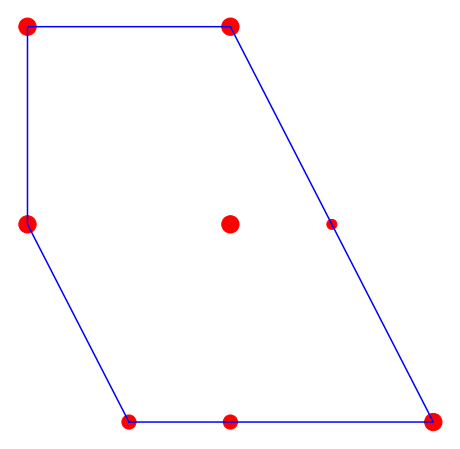

In [41]:
P_opt = np.array([[0,4],[0,4],[0,4],[2,4],[2,4],[2,4],[0,2],[0,2],[0,2],[2,2],[2,2],[2,2],[3,2],[1,0],[1,0],[2,0],[2,0],[4,0],[4,0],[4,0]])
print("Optimal log D-optimality criterion:", end = " ")
print(OD.opt(P_opt))
OD.plot(P_opt)

log D-optimality criterion for DOGS after 200 iterations: -20.957990302873544
log D-optimality criterion for LSA after 2000 iterations: -20.530395778757
log D-optimality criterion for ExM after 200 iterations: -20.571476419936126


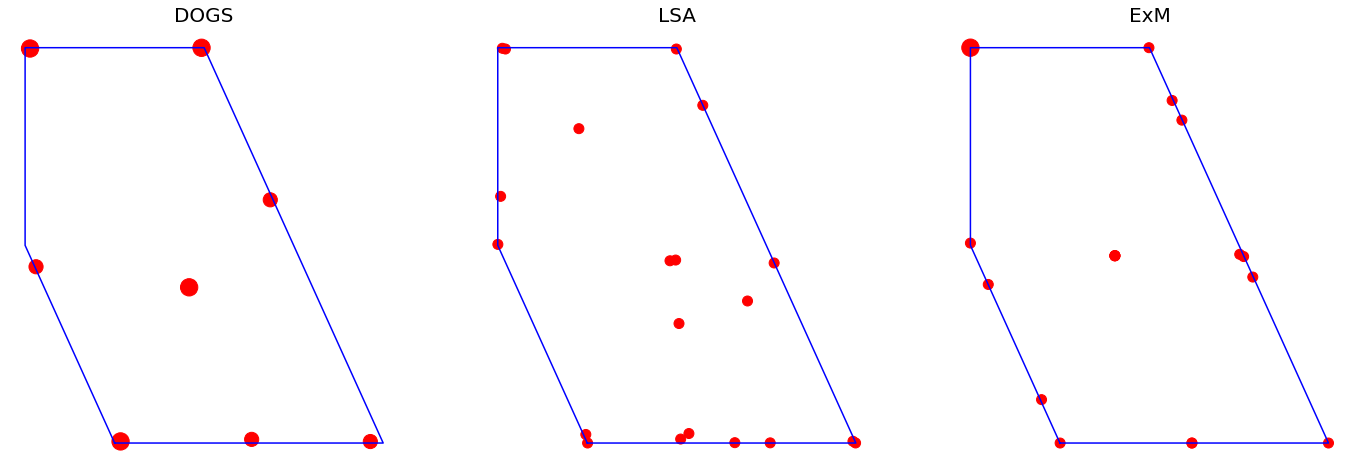

In [43]:
Algo_DOGS = DOGS(OD,50)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for DOGS after 200 iterations:", end = " ")
print(OD.opt(P1))

Algo_LSA = LSA(OD,0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for LSA after 2000 iterations:", end = " ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for ExM after 200 iterations:", end = " ")
print(OD.opt(P3))

fig=OD.plot((P1,P2,P3),modify_plot = True)
fig.axes[0].set_title("DOGS", fontsize = 20)
fig.axes[1].set_title("LSA", fontsize = 20)
fig.axes[2].set_title("ExM", fontsize = 20)
fig

In [44]:
algo_tuple = (DOGS(OD,50),LSA(OD,0.01),LSA(OD,0.05),LSA(OD,0.1),ExM(OD))
depth = 200
N_test = 10
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth,N_test,progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res,axis=0)]
    List_quantile_low += [np.quantile(sim_res,quantile,axis=0)]
    List_quantile_high += [np.quantile(sim_res,1-quantile,axis=0)]

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done


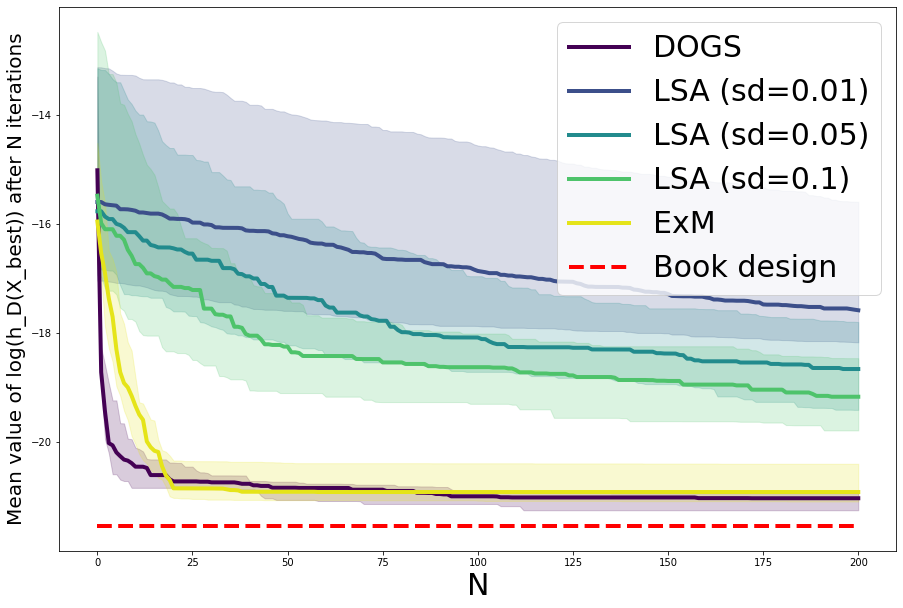

Average time for one realization of 200 iterations of DOGS: 6.365sec
Average time for one realization of 200 iterations of LSA: 0.134sec
Average time for one realization of 200 iterations of ExM: 1.152sec


In [45]:
#Plotting the results

plt.figure(figsize = (15,10))
viridis = plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k],linewidth = 4, color = viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0,depth],[OD.opt(P_opt),OD.opt(P_opt)],'r--', linewidth = 4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color = viridis(k*0.24), alpha = .2)

plt.legend(labels = ["DOGS","LSA (sd=0.01)","LSA (sd=0.05)","LSA (sd=0.1)","ExM","Book design"],fontsize = 30)
plt.xlabel('N',fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations',fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');

# 4. Mixture model with linear constraints

This example is taken from Example 16.2 in the book "Optimum Experimental Designs, with SAS" by Atkinson, Donev and Tobias. Note that we consider here the design space in the two variables $x_1$ and $x_2$ while in the book they consider the simplex plot corresponding the mixture design problem. We show here the plots of the design in both our design space and their simplex plot.

log D-optimality criterion for this random design chosen with a uniform distribution: 14.885305888617804


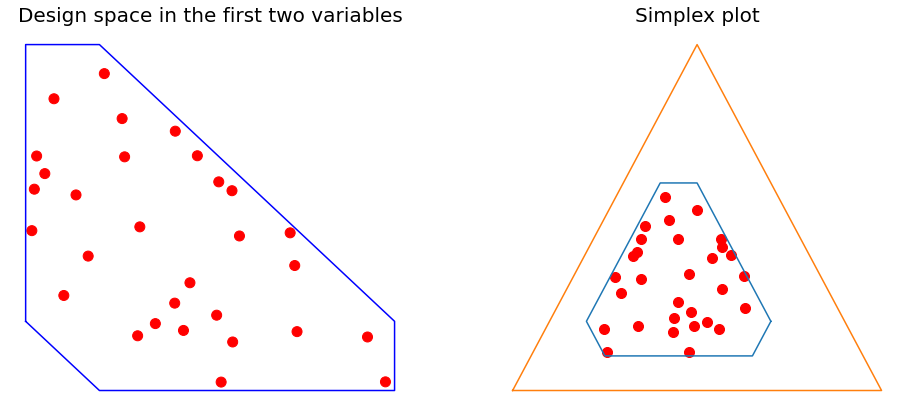

In [51]:
PHI = PHImono(2,2)

def SimplexCara(P):
    Bool_Ar = np.logical_and(P[:,0] >= 0.2,P[:,0] <= 0.7)
    Bool_Ar = np.logical_and(Bool_Ar,P[:,1] >= 0.1)
    Bool_Ar = np.logical_and(Bool_Ar,P[:,1] <= 0.6)
    Bool_Ar = np.logical_and(Bool_Ar,np.round(1-(P[:,1]+P[:,0]),10) >= 0.1)
    Bool_Ar = np.logical_and(Bool_Ar,np.round(1-(P[:,1]+P[:,0]),10) <= 0.6)
    return(Bool_Ar)

def Simplexplot(ax):
    ax.plot([0.2,0.2,0.3,0.7,0.7,0.3,0.2],[0.2,0.6,0.6,0.2,0.1,0.1,0.2],'b')
    ax.axis("off")
    return ax

OD = OptDesign(PHI,[0,0],[1,1],nbpoint = 30,cara = SimplexCara,plot_fun = Simplexplot)
P = OD.Urand(OD.nbpoint)
print("log D-optimality criterion for this random design chosen with a uniform distribution:", end = " ")
print(OD.opt(P))
fig=OD.plot(P,modify_plot = True)

#Drawing the simplex plot
fig.axes[0].change_geometry(1, 2, 1)
fig.axes[0].set_title("Design space in the first two variables", fontsize=20)
fig.add_subplot(1, 2, 2)
fig.set_size_inches(16,7)

A = np.array([0.2,0.2,0.3,0.7,0.7,0.3,0.2])
B = np.array([0.2,0.6,0.6,0.2,0.1,0.1,0.2])

A = 1-A-B/2
B *= np.sqrt(5)/2

Q = np.copy(P)
Q[:,0] = 1-P[:,0]-P[:,1]/2
Q[:,1] *= np.sqrt(5)/2

fig.axes[1].plot(A,B)
fig.axes[1].plot([0,0.5,1,0],[0,np.sqrt(5)/2,0,0])
fig.axes[1].axis("off")
fig.axes[1].scatter(Q[:,0],Q[:,1],marker = 'o',c = 'r',s = 100)
fig.axes[1].set_title("Simplex plot", fontsize = 20)
fig

The authors also shares the optimal design they found using a discrete exchange method on a set of well-chosen candidate points. This is Figure 16.3 in Atkinson's book.

Optimal log D-optimality criterion: 9.753297144306606


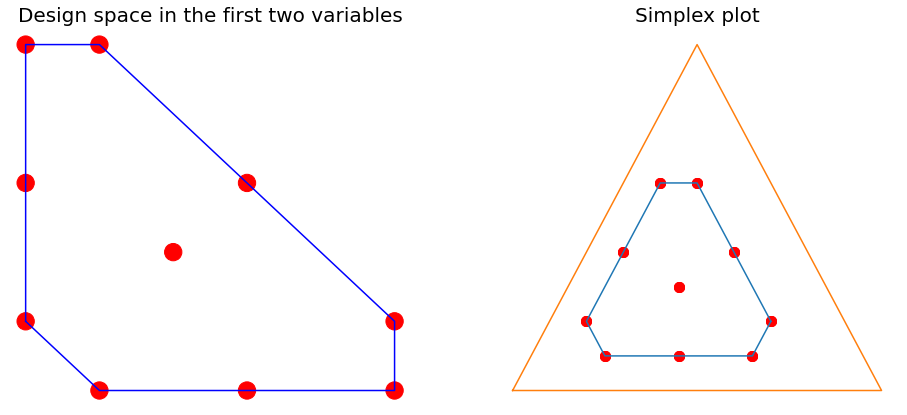

In [50]:
P_opt=np.array([[0.7,0.1],[0.2,0.6],[0.7,0.2],[0.2,0.2],[0.3,0.6],[0.3,0.1],[0.2,0.4],[0.5,0.1],[0.5,0.4],[0.4,0.3]])
P_opt=np.vstack((P_opt,P_opt,P_opt))
print("Optimal log D-optimality criterion:", end = " ")
print(OD.opt(P_opt))
fig = OD.plot(P_opt,modify_plot = True)

#Drawing the simplex plot
fig.axes[0].change_geometry(1, 2, 1)
fig.axes[0].set_title("Design space in the first two variables", fontsize = 20)
fig.add_subplot(1, 2, 2)
fig.set_size_inches(16,7)

Q = np.copy(P_opt)
Q[:,0] = 1-P_opt[:,0]-P_opt[:,1]/2
Q[:,1] *= np.sqrt(5)/2

fig.axes[1].plot(A,B)
fig.axes[1].plot([0,0.5,1,0],[0,np.sqrt(5)/2,0,0])
fig.axes[1].axis("off")
fig.axes[1].scatter(Q[:,0],Q[:,1],marker = 'o',c = 'r',s = 100)
fig.axes[1].set_title("Simplex plot", fontsize = 20)
fig

Now, testing our algorithms in this case gives:

log D-optimality criterion for one realization of DOGS after 200 iterations: 10.27334657195556
log D-optimality criterion for one realization of LSA after 2000 iterations: 11.44186403722205
log D-optimality criterion for one realization of ExM after 200 iterations: 11.392052027007853


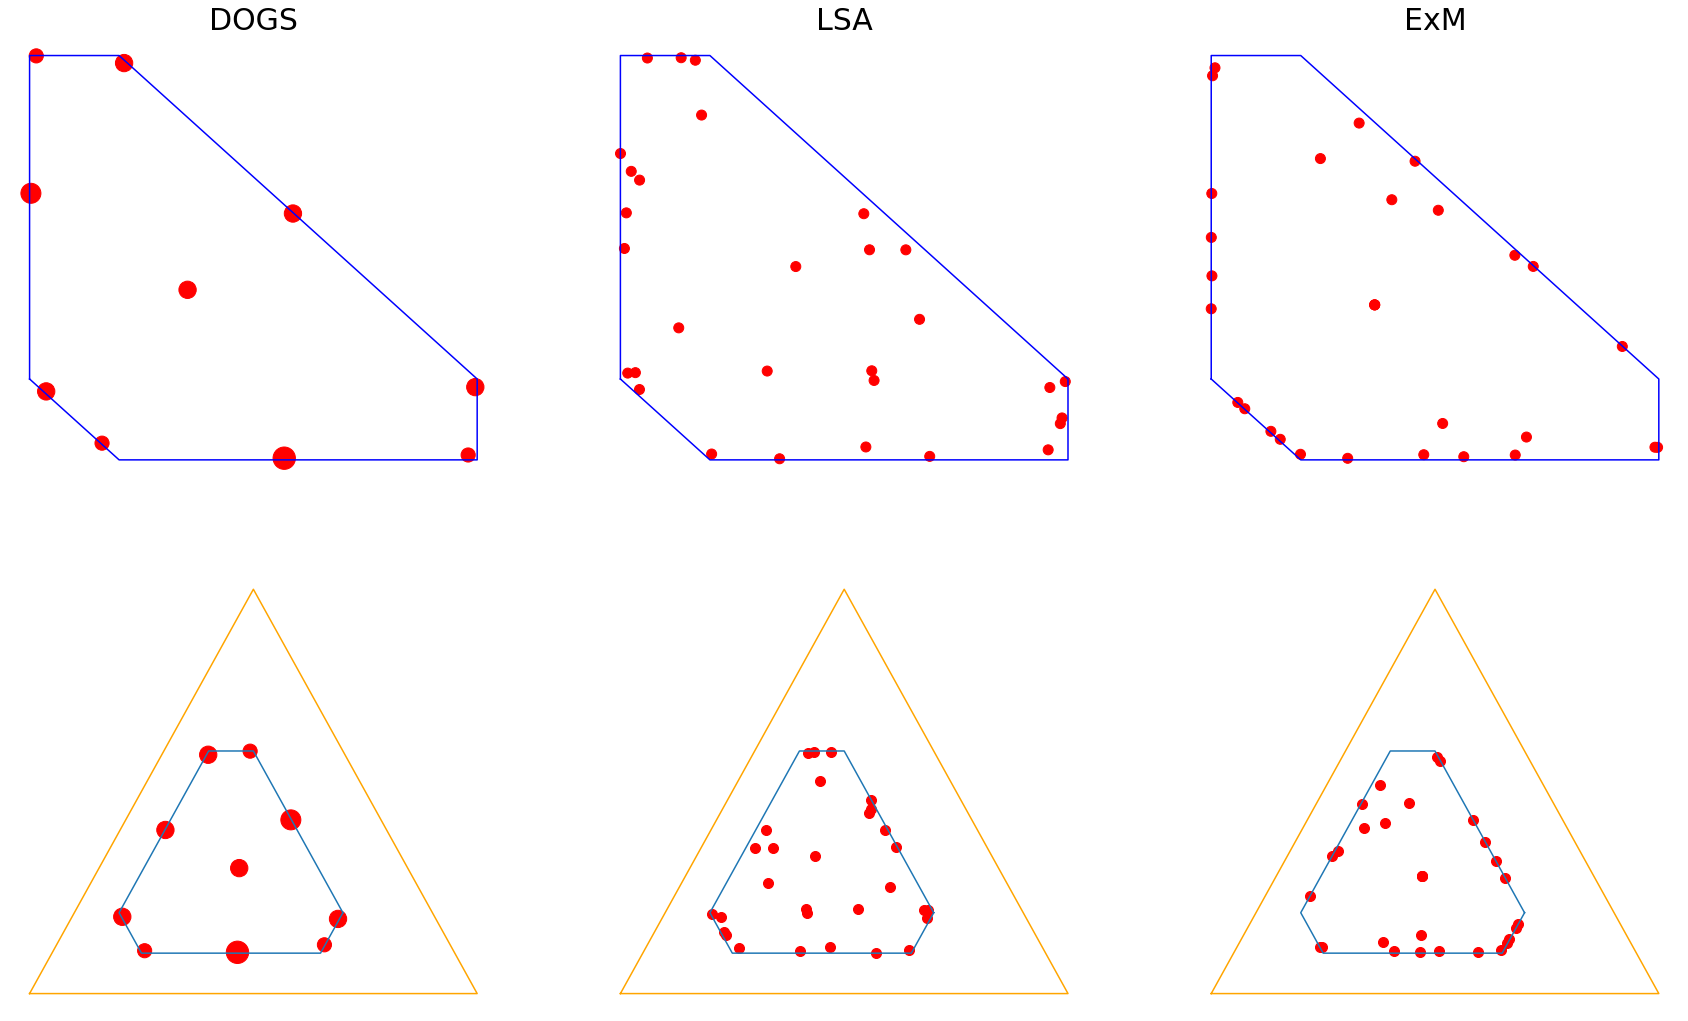

In [52]:
Algo_DOGS = DOGS(OD,50)
P1 = Algo_DOGS.simulate(200)
print("log D-optimality criterion for one realization of DOGS after 200 iterations:", end = " ")
print(OD.opt(P1))

Algo_LSA = LSA(OD,0.05)
P2 = Algo_LSA.simulate(2000)
print("log D-optimality criterion for one realization of LSA after 2000 iterations:", end = " ")
print(OD.opt(P2))

Algo_ExM = ExM(OD)
P3 = Algo_ExM.simulate(200)
print("log D-optimality criterion for one realization of ExM after 200 iterations:", end = " ")
print(OD.opt(P3))

fig=OD.plot((P1,P2,P3),modify_plot = True)

#Drawing the simplex plot
fig.axes[0].set_title("DOGS", fontsize = 30)
fig.axes[1].set_title("LSA", fontsize = 30)
fig.axes[2].set_title("ExM", fontsize = 30)

fig.axes[0].change_geometry(2, 3, 1)
fig.axes[1].change_geometry(2, 3, 2)
fig.axes[2].change_geometry(2, 3, 3)
fig.add_subplot(2, 3, 4)
fig.add_subplot(2, 3, 5)
fig.add_subplot(2, 3, 6)
fig.set_size_inches(30,18)

Q1 = np.copy(P1)
Q1[:,0] = 1-P1[:,0]-P1[:,1]/2
Q1[:,1] *= np.sqrt(5)/2

Q2 = np.copy(P2)
Q2[:,0] = 1-P2[:,0]-P2[:,1]/2
Q2[:,1] *= np.sqrt(5)/2

Q3 = np.copy(P3)
Q3[:,0] = 1-P3[:,0]-P3[:,1]/2
Q3[:,1] *= np.sqrt(5)/2

fig.axes[3].plot(A,B)
fig.axes[3].plot([0,0.5,1,0],[0,np.sqrt(5)/2,0,0],'orange')
fig.axes[3].axis("off")
Pt, Nb = np.unique([tuple(row) for row in Q1], axis = 0,return_counts = True)
fig.axes[3].scatter(Pt[:,0],Pt[:,1],marker = 'o',c = 'r',s = 100*Nb)

fig.axes[4].plot(A,B)
fig.axes[4].plot([0,0.5,1,0],[0,np.sqrt(5)/2,0,0],'orange')
fig.axes[4].axis("off")
fig.axes[4].scatter(Q2[:,0],Q2[:,1],marker = 'o',c='r',s = 100)

fig.axes[5].plot(A,B)
fig.axes[5].plot([0,0.5,1,0],[0,np.sqrt(5)/2,0,0],'orange')
fig.axes[5].axis("off")
fig.axes[5].scatter(Q3[:,0],Q3[:,1],marker = 'o',c = 'r',s = 100)
fig

In [53]:
algo_tuple = (DOGS(OD,50),LSA(OD,0.01),LSA(OD,0.05),LSA(OD,0.1),ExM(OD))
depth = 200
N_test = 10
quantile = 0.05

List_time = []
List_all = []
List_median = []
List_quantile_low = []
List_quantile_high = []
for algo in algo_tuple:
    t = time.time()
    sim_res = algo.testing(depth,N_test,progress=True)
    List_time += [time.time()-t]
    List_all += [sim_res]
    List_median += [np.median(sim_res,axis=0)]
    List_quantile_low += [np.quantile(sim_res,quantile,axis=0)]
    List_quantile_high += [np.quantile(sim_res,1-quantile,axis=0)]

Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done
Progress: 100.00% Done


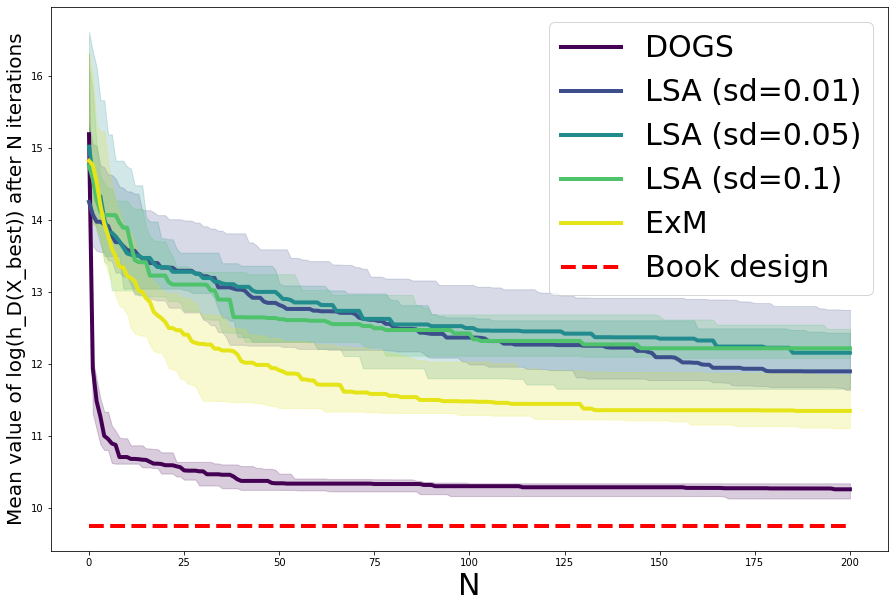

Average time for one realization of 200 iterations of DOGS: 6.858sec
Average time for one realization of 200 iterations of LSA: 0.160sec
Average time for one realization of 200 iterations of ExM: 3.343sec


In [54]:
#Plotting the results

plt.figure(figsize = (15,10))
viridis = plt.cm.get_cmap('viridis')

for k in range(5):
    plt.plot(List_median[k],linewidth = 4, color = viridis(k*0.24))
m = np.median(Discrete_Result)
plt.plot([0,depth],[OD.opt(P_opt),OD.opt(P_opt)],'r--', linewidth = 4)
    
for k in range(5):
    Q_low = List_quantile_low[k]
    Q_high = List_quantile_high[k]
    plt.fill_between(np.arange(depth+1), Q_low, Q_high, color = viridis(k*0.24), alpha = .2)

plt.legend(labels = ["DOGS","LSA (sd=0.01)","LSA (sd=0.05)","LSA (sd=0.1)","ExM","Book design"],fontsize = 30)
plt.xlabel('N',fontsize = 30)
plt.ylabel('Mean value of log(h_D(X_best)) after N iterations',fontsize=20)
plt.show()
print(f'Average time for one realization of {depth} iterations of DOGS: {List_time[0]/(N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of LSA: {(List_time[1]+List_time[2]+List_time[3])/(3*N_test):.3f}sec')
print(f'Average time for one realization of {depth} iterations of ExM: {List_time[4]/(N_test):.3f}sec');